## 3️⃣ Statistical Inference & Feature Engineering


In [19]:
import warnings

# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from IPython.display import display
from yellowbrick.base import Visualizer
import geopy.distance
from shapely.geometry import Point
import requests
import geopandas as gpd
import pyarrow as pa
import fastparquet as fp
import os

from R2_functions import univariate_outlier_removal
from R3_functions import chain_snap, one_way_ANOVA, correlation_analysis, plot_correlogram
# set random seed
np.random.seed(42)

**1. Start the analysis by processing the training dataset based on the findings obtained in the Exploratory Data Analysis (EDA), e.g., by dealing with missing values and removing duplicates if necessary;**
<!-- - 💁‍♂️ Try to tailor the [datatype](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) as much as possible. -->

* Used chain method to read and process data beforehand, with additional log transformation on several variables.  

In [20]:
# load data_info csv
data_info = pd.read_csv("./data/data_info.csv", index_col=0)
display(data_info.transpose())

# load training data
data_train = (
    # load csv
    pd.read_csv("./data/data_train.csv")
    # remove rows missing values, if any
    .pipe(
        chain_snap,
        fn=lambda df: df.isna().sum().sum(),
        msg="• Number of missing values that will be removed",
    )
    .dropna(how="any")
    # drop duplicates, if any
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="• Number of duplicate rows that will be removed",
    )
    .drop_duplicates()
    # create log-transformed of skewed features, namely Price, Area and Room
    .assign(
        **{
            "log(Price)": lambda df: np.log(df["Price"]),
            "log(Area)": lambda df: np.log(df["Area"]),
            "log(Room)": lambda df: np.log(df["Room"]),
        }
    )
)

# define the target
TARGET = "Price"

# display some info
display(data_train.head(3))
print(f"• Size dataframe = {data_train.shape}")

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,nominal,nominal,continuous,discrete,continuous,continuous


• Number of missing values that will be removed: 2
• Number of duplicate rows that will be removed: 0


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room)
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016,13.361380,4.394449,1.098612
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057 ZW,61,2,4.858697,52.370661,12.899220,4.110874,0.693147
2,695000.0,"Da Costakade 171 III, Amsterdam",1053 WX,88,3,4.874092,52.367502,13.451667,4.477337,1.098612


• Size dataframe = (552, 10)


* Since house price data depends heavily on geolocations, I used [geopandas](https://github.com/geopandas/geopandas) as part of feature engineering, in order to pull out the distance to [city center](https://www.amsterdamsights.com/about/dam.html#:~:text=Dam%20Square%20lies%20in%20the,by%20the%20neoclassical%20Royal%20Palace.) &  borough information for each property.

In [21]:
# Assuming Dam Square as the heart of city, in this way we can compute each houses distance to center point 

# Input the coordinates of the Dam Square as city centre
city_centre = (52.373095, 4.893055)  
# Create new column calculate distance to city centre 
data_train['km_to_centre'] = data_train.apply(lambda row: geopy.distance.geodesic((row['Lat'], row['Lon']), city_centre).km, axis=1)

In [22]:
warnings.filterwarnings('ignore')
# retrieve the geojson file from the Amsterdam Open Data Portal
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_STADSDEEL&THEMA=gebiedsindeling"
gdf_districts = (
    gpd.read_file(requests.get(url).text)
    .drop(columns=["Stadsdeelcode", "Oppervlakte_m2"])
    .reset_index(drop=True)
    .rename(columns={"Stadsdeel": "Borough"})
)

# compute point geometry coordinate for each property in the train set
geometry = [Point(xy) for xy in zip(data_train.Lon, data_train.Lat)]
data_train = gpd.GeoDataFrame(data_train, geometry=geometry,crs="EPSG:4326")
#Mapping trainset to corresponding borough information, by using left join to keep all the observations from train set 
data_train = gpd.sjoin(data_train,gdf_districts,  how='left',op= 'intersects') 

# Rename and convert 'Borough_id' column to integer
data_train = data_train.rename(columns={"index_right": "Borough_id"})
data_train["Borough_id"]= data_train['Borough_id'].astype(np.float64).astype("Int64")
data_train['Borough'] = data_train['Borough'].astype('category')
# drop geometry column from train set
data_train = data_train.drop(columns=['geometry'])

print(f"• Size dataframe = {data_train.shape}")
display(data_train.sample(3))


• Size dataframe = (552, 13)


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),km_to_centre,Borough_id,Borough
549,495000.0,"Waterkeringweg 49, Amsterdam",1051 NX,74,3,4.867549,52.384604,13.112313,4.304065,1.098612,2.157968,6,West
81,485000.0,"Meeuwenlaan 175 B, Amsterdam",1021 JC,93,5,4.918067,52.385525,13.091904,4.532599,1.609438,2.194091,5,Noord
140,500000.0,"Venetiëhof 10, Amsterdam",1019 NA,84,3,4.947231,52.377422,13.122363,4.430817,1.098612,3.720793,1,Oost


Borough_id,0,1,3,4,5,6,7,8
Borough,Centrum,Oost,Nieuw-West,Zuidoost,Noord,West,Weesp,Zuid
0,85,73,103,44,65,103,1,77


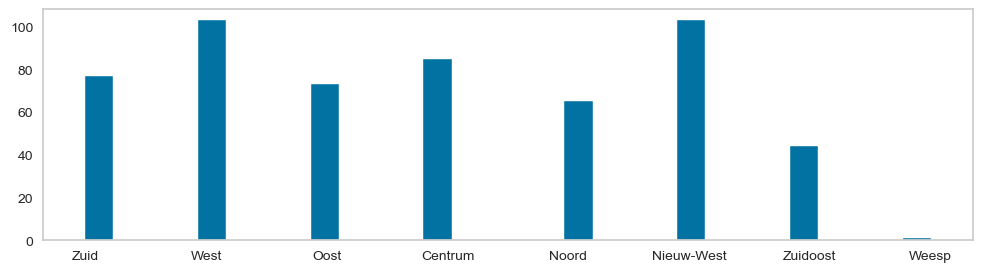

In [23]:
import matplotlib.pyplot as plt

# Display the distribution of train set by borough
house_count_by_borough = pd.DataFrame(data_train[['Borough_id','Borough']].value_counts())
display(house_count_by_borough.sort_values(by='Borough_id').transpose())

# Visualise the distribution of train set by borough
data_train.Borough.hist( bins = 30,figsize=(12,3))
plt.grid(False)
plt.show()

In [24]:
# Tailor data type
data_train = data_train.astype(
    {
        "Price": "float64",
        "log(Price)": "float64",
        "Address": "category",
        "Zip": "category",
        "Area": "float64",
        "log(Area)": "float64",
        "Room": "float64",
        "log(Room)": "float64",
        "Lon": "float64",
        "Lat": "float64",
        "km_to_centre": "float64",
        "Borough_id": "category",
        "Borough": "category",
        
    }
)

# add to data_info additional info regarding the new log-transformed features
data_info = pd.concat(
    [
        data_info,
        pd.Series(
            {
                "log(Price)": "continuous",
                "log(Area)": "continuous",
                "log(Room)": "continuous",
                # "km_to_centre": "continuous",
                # "Borough_id": "Discrete",
                "Borough": "nominal",
            },
            name="data_type",
        ).to_frame(),
    ],
    axis=0,
)

**2. Study the relationship between variables using conventional statistical tools, namely:** 

* Considered following types of test can be constructed, and selected ANOVA & t-tests based on the data type at hand between features and target variables: 
    - **a.** $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
    - **b.** $\chi^{2}$ or [Spearman’s rank](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php) correlation analysis between two **Ordinal** variables;
    - **c.** [Correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis for both **Discrete** and **Continuous** variables;
    - **d.** An appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to assess the relationship between **Numerical** and **Categorical** variables.   

<!-- ⭐️ Use the [p-value](https://www.investopedia.com/terms/p/p-value.asp) to convey the statistical significance of the results. If, for instance, we would obtain a correlation between variables of $r=0.5$ with $p<0.001$, it means there is a $0.1%$ probability that we would observe an r-value different than $0.5$. -->

<!-- 💁‍♀️ Look closely at the relationship between the dependent variable, i.e., the target and the independent variables, i.e., the features, as they will provide an insight into candidate predictors. 

💁‍♂️ Whenever possible, visualize the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced groups.

👷 Transform and/or construct new features and apply appropriate statistical tests. -->



**a.** Analysis of **Nominal** features

In [25]:
# get list of nominal features from orignal dataset
nominal_list = list(data_info.loc[lambda x: x["data_type"] == "nominal"].index)
print(f"• Nominal features: {', '.join(nominal_list)}")

• Nominal features: Address, Zip, Borough


- For the the two nominal features from the original dataset, conducting statistical analysis will not be sensible. This is because: Address variable is very granular (i.e.,unique at individual house level), whereas Zip code seems to show patterns depending city of houses. 
- Yet, we can extract some useful features as follows:
    - Extrapolate the city from `Address` as it is expected that the house `Price` will depend on the city, most likely Amsterdam having the highest Price on average;
    - According to this [reference](https://en.youbianku.com/Netherlands), the `Zip` code is based on four digits followed by two letters, e.g. 1234 AB. The first two digits indicate a `City` and a `Region`, the third digit represents the `Location`, and the fourth digit represents the `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. 
    
- Thus, one can create several features based on a subsection of the Zip code.

In [26]:
# remove any space in the Zip string
data_train["Zip"] = data_train["Zip"].str.replace(" ", "")

# create new features from Address and Zip
data_train = data_train.assign(
    **{
        #Extract city name from Address variable
        "City": lambda df: df["Address"].str.split().str[-1],  # last word
        
        #Extract Zip number,city number, region, locarion, district, delivery area from Zip variable
        "Zip_num": lambda df: df["Zip"].str[:4].astype(int),     # first 4 digits
        "City_number": lambda df: df["Zip"].str[0].astype(int),  # first digit
        "Region": lambda df: df["Zip"].str[1].astype(int),       # second digit
        "Location": lambda df: df["Zip"].str[2].astype(int),     # third digit
        "District": lambda df: df["Zip"].str[3].astype(int),     # fourth digit
        "Delivery_area": lambda df: df["Zip"].str[4:],           # from fifth digit
    }
)

print(f"• Size dataframe = {data_train.shape}")
display(data_train.head(3))


• Size dataframe = (552, 20)


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),km_to_centre,Borough_id,Borough,City,Zip_num,City_number,Region,Location,District,Delivery_area
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078VH,81.0,3.0,4.894509,52.343016,13.361380,4.394449,1.098612,3.348481,8,Zuid,Amsterdam,1078,1,0,7,8,VH
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057ZW,61.0,2.0,4.858697,52.370661,12.899220,4.110874,0.693147,2.355658,6,West,Amsterdam,1057,1,0,5,7,ZW
2,695000.0,"Da Costakade 171 III, Amsterdam",1053WX,88.0,3.0,4.874092,52.367502,13.451667,4.477337,1.098612,1.433694,6,West,Amsterdam,1053,1,0,5,3,WX


In [27]:
# Tailor data type for new features
data_train = data_train.astype(
    {
        "Zip_num": "category",
        "City": "category",
        "City_number": "category",
        "Region": "category",
        "Location": "category",
        "District": "category",
        "Delivery_area": "category",
    }
)

# show summary statistics of the new features
data_train[
    [
        "Zip_num",
        "City",
        "City_number",
        "Region",
        "Location",
        "District",
        "Delivery_area",
        "Borough",
    ]
].describe()

,Zip_num,City,City_number,Region,Location,District,Delivery_area,Borough
count,552,552,552,552,552,552,552,551
unique,69,1,1,2,9,10,295,8
top,1017,Amsterdam,1,0,1,7,EE,Nieuw-West
freq,22,552,552,507,106,84,8,103


* As expected this dataset contains only Houses located in Amsterdam. As a consequence, `City_number` as well as `City` will be discarded since they hold only one value.

In [28]:
# drop City_number and City as these variables have no variance
_ = data_train.drop(columns=["City_number", "City"], inplace=True)

In [29]:
# add the new features to the nominal list
nominal_list = nominal_list + [
    "Zip_num",
    "Region",
    "Location",
    "District",
    "Delivery_area",
]

# Print list without going new line
print(f"• Nominal features: {', '.join(nominal_list)}")

• Nominal features: Address, Zip, Borough, Zip_num, Region, Location, District, Delivery_area


,test-type,feature,group-var,f-value,eta-squared,df-effect,df-error,p-value,stat-sign,variance,results
0,one way ANOVA,log(Price),Zip_num,267.003,0.974,68,481,0.000,True,Unequal,Alexander-Govern
1,one way ANOVA,log(Price),Region,110.482,0.167,1,551,0.000,True,Unequal,Alexander-Govern
2,one way ANOVA,log(Price),Location,180.731,0.727,8,544,0.000,True,Unequal,Alexander-Govern
3,one way ANOVA,log(Price),District,2.284,0.036,9,543,0.016,True,Equal,ANOVA
4,one way ANOVA,log(Price),Borough,174.890,0.721,8,542,0.000,True,Unequal,Alexander-Govern


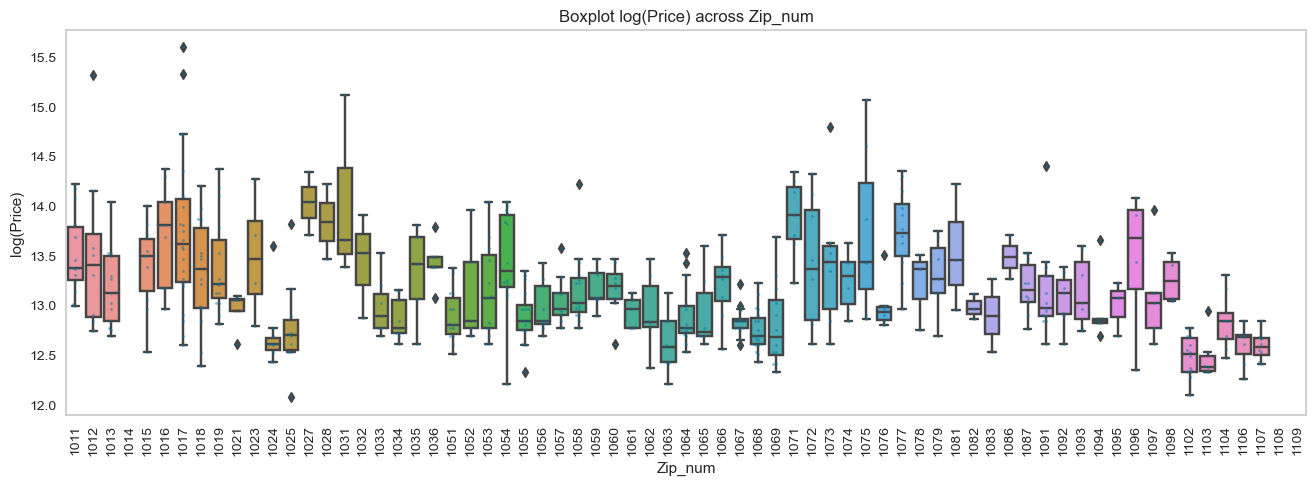

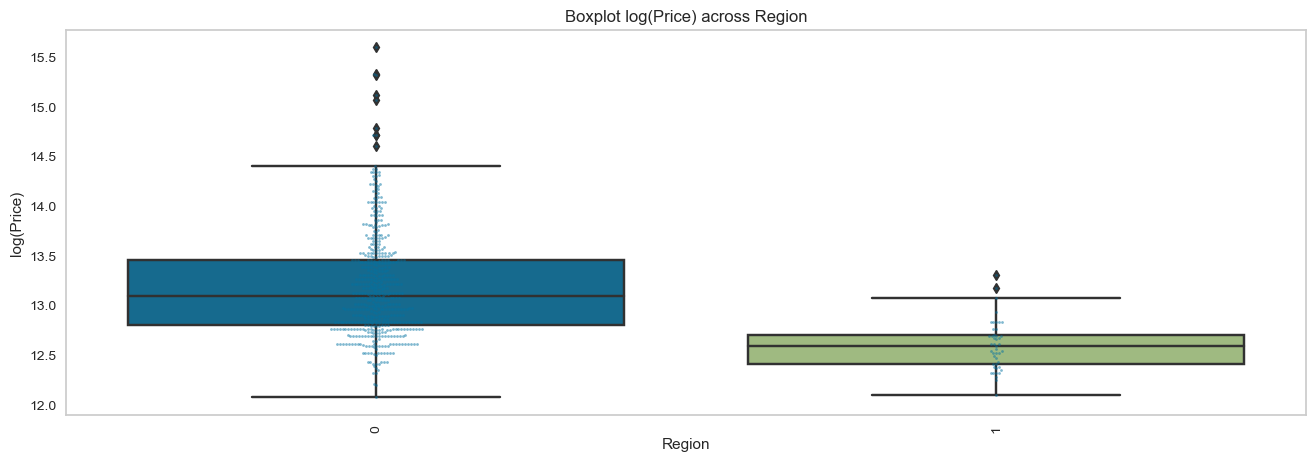

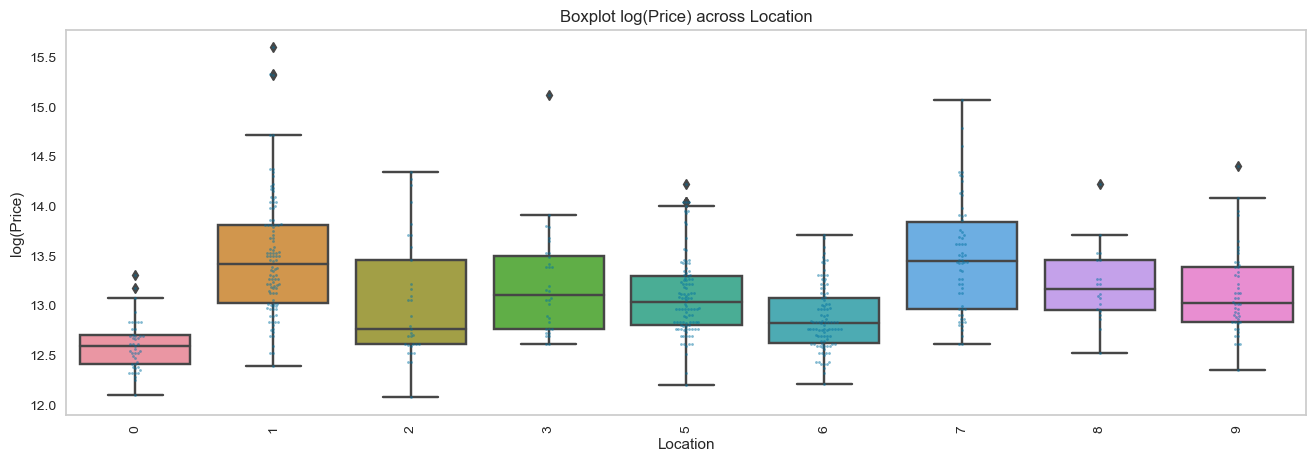

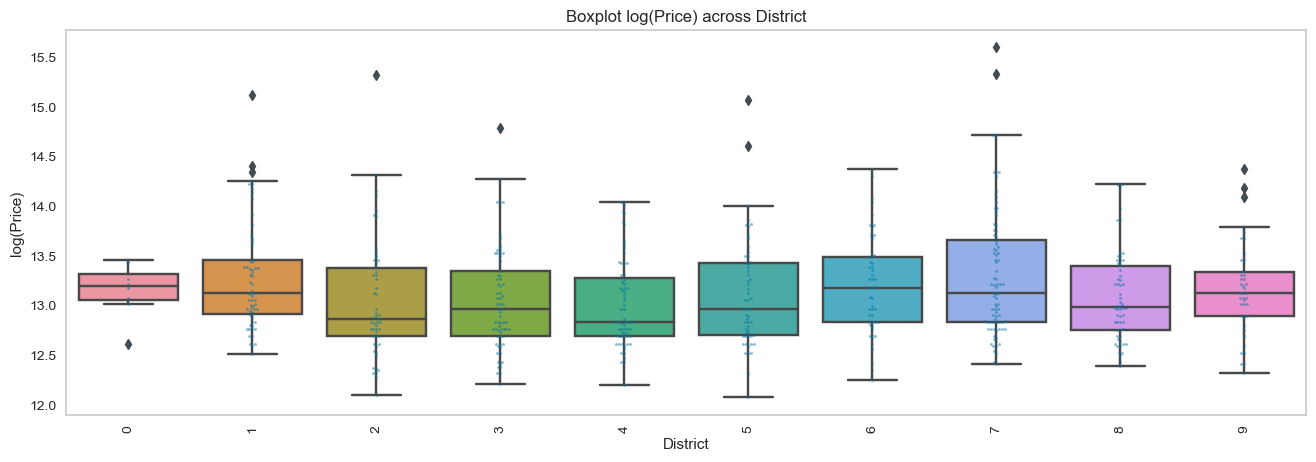

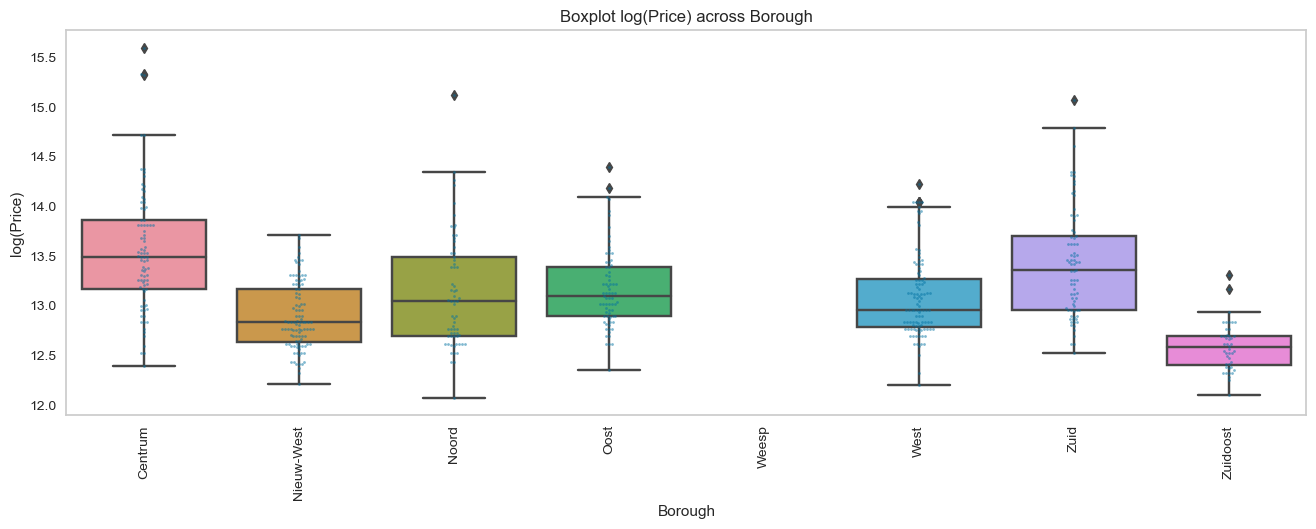

In [30]:
# check if it exists statistical significance between nominal features and target
df_summary_anova = pd.DataFrame()

# loop through list
for col in ["Zip_num", "Region", "Location", "District", "Borough"]:
    # carry out t-test
    df_anova, df_descriptive, _, _ = one_way_ANOVA(
        data=data_train,
        feature="log(Price)",
        grouping_var=col,
        groups_of_interest=data_train[col].unique(),
        plot=True,
        figsize=(16, 5),
    )

    # concatenate to summary dataframe
    df_summary_anova = pd.concat([df_summary_anova, df_anova], ignore_index=True)

display(df_summary_anova)

* Anova results revealed there is statistical differences between the means for each categorical variable. However, combined with the boxplots above, we can conclude that: 
    - One can observe some group difference in `Region` and `Location`
    - `Zip_num` is fairly granular, and may not be a good feature to use predicting house prices 
    - The effect size of `District` on `log(Price)` is quite small, indicating `District` attributed small variation on target variable; thus not a meaningful feature for predicting house prices 
    - Lastly, although `Borough` showed large variation in `log(Price)`, considering its computational need in feature engineering and reliance on external package that is not as highly maintained as pandas package, this variable seems less optimal to be included.  

**b.** Analysis of **Ordinal** features

In [31]:
# collect ordinal features
data_info.loc[lambda x: x["data_type"] == "ordinal"]
ordinal_list = list(data_info.loc[lambda x: x["data_type"] == "ordinal"].index)
print(ordinal_list) # No ordinal features from train set

[]


* No ordinal features are present in this dataset.

**c.** Analysis of **Discrete** and **Continuous** features

In [32]:
# Collect quantitative features
quantitative_list = data_info.loc[
    lambda x: (x["data_type"] == "discrete") | (x["data_type"] == "continuous")
                                    ].index.to_list()

print(f"• Quantitative features: {', '.join(quantitative_list)}")

# Split the target and features into separate lists
target_list = ["Price", "log(Price)"]

features_list = quantitative_list.copy()

_ = [features_list.remove(item) for item in target_list]

• Quantitative features: Price, Area, Room, Lon, Lat, log(Price), log(Area), log(Room)


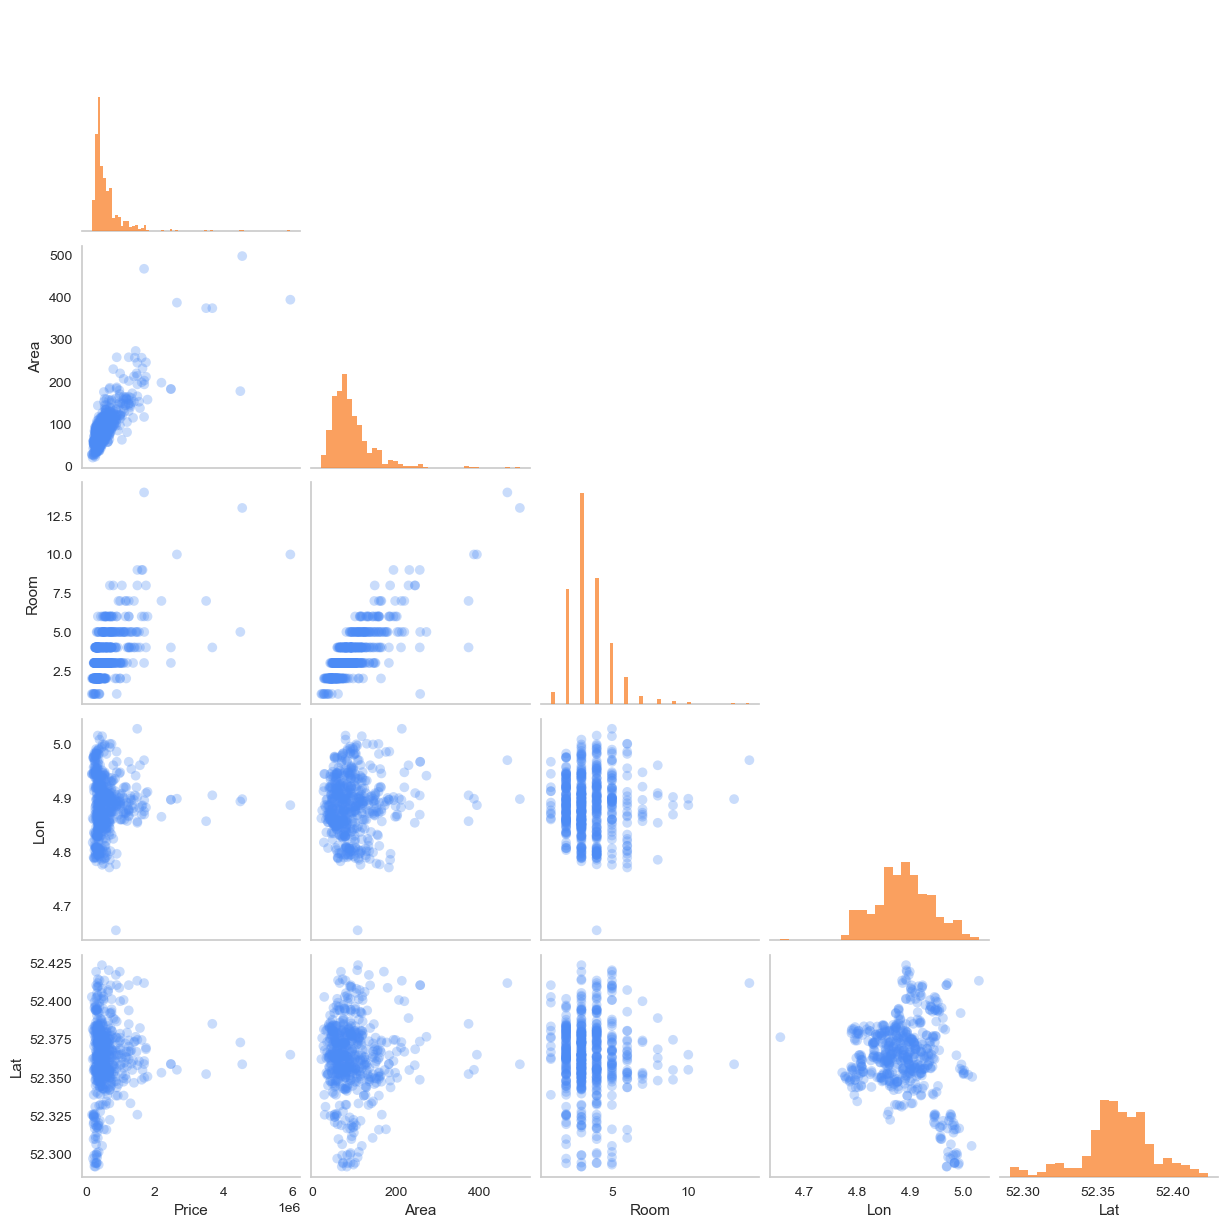

In [33]:
# Let's first visualize the original features using a pairplot
sns.pairplot(
    data=data_train,
    
    # consider only elements without log in quantitative list
    vars=[item for item in quantitative_list if "log" not in item],
    
    # plot only half diagnal
    corner=True,
    
    # customize pairplot colors
    diag_kws={
        "color": '#F9812A',
        "multiple": "stack",
        "edgecolor": "none",
    },
    
    plot_kws={"color": '#4C8BF5', "alpha": 0.3, "edgecolor": "none"},
)

sns.set_style("whitegrid", {'axes.grid' : False})

plt.show()

* From the pair plot, we observe that:
    - `Price`, `Area` and `Room` are right-skewed as already observed during the EDA;
    - `Room` and `Area` appear positively correlated, which makes sense as the Area increases as the number of rooms increases. We can attempt to create a new feature called `AR-ratio` in order to reduce [multicollinearity](https://www.investopedia.com/terms/m/multicollinearity.asp#:~:text=Multicollinearity%20is%20a%20statistical%20concept,in%20less%20reliable%20statistical%20inferences.) issues during model training by dividing the total Area of the house by the number of rooms with unit $m^{2}$.
    - `Area` is positively correlated with `Price`, making it a good candidate as a predictor. However, the standard deviation of `Price`, monitored over different values of `Area`, is non-constant, leading to possible [Heteroskedasticity](https://www.investopedia.com/terms/h/heteroskedasticity.asp) issues. 
    - `Lon` and `Lat` seem unrelated to `Price`. We will attempt to engineer new features based on business knowledge.

In [34]:
# create AR-ratio and the corresponding log transform feature
data_train = data_train.assign(
    **{
        "AR-ratio": lambda df: df["Area"] / df["Room"],
        "log(AR-ratio)": lambda df: np.log(df["Area"] / df["Room"]),
    }
)

# append new features to quantitative list
quantitative_list.extend(["AR-ratio","log(AR-ratio)"])
features_list.extend(["AR-ratio","log(AR-ratio)"])


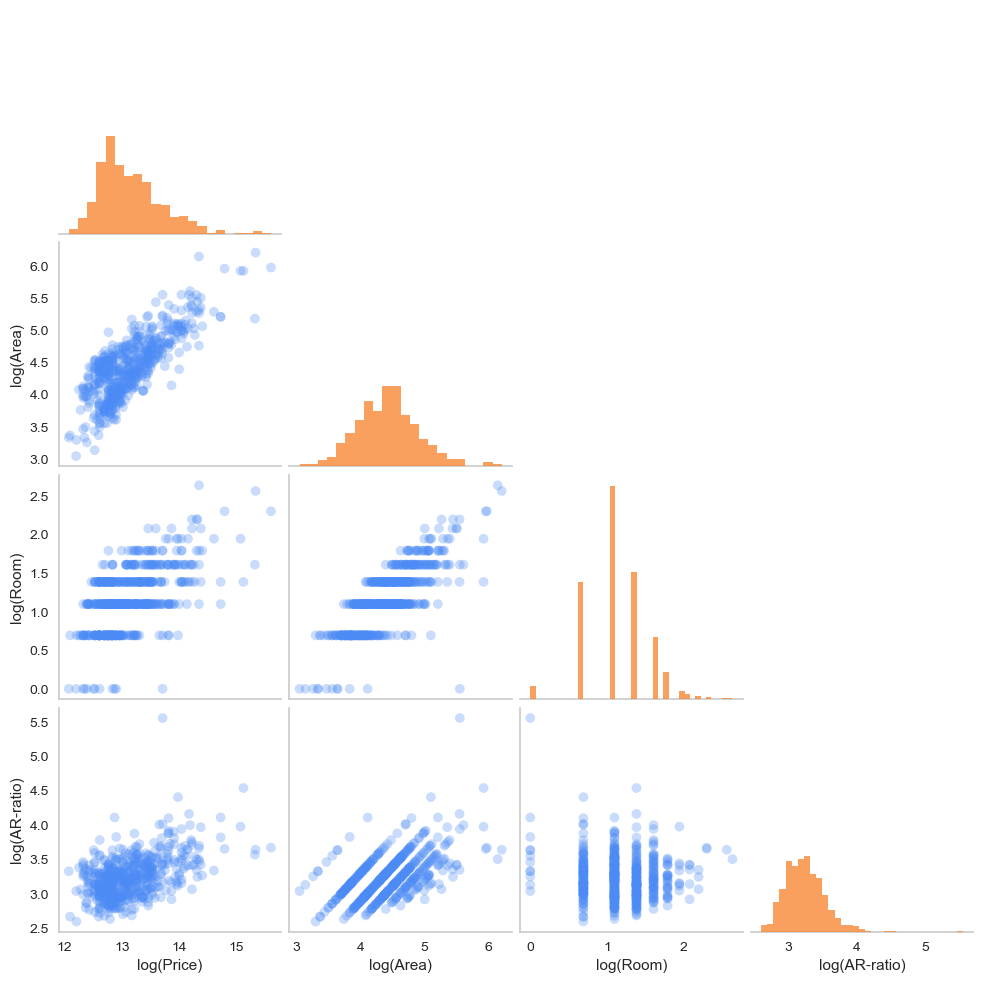

In [35]:
# Let's visualize the log-transformed features
sns.pairplot(
    data=data_train,
    # consider only elements without log in quantitative list
    vars=[item for item in quantitative_list if "log" in item],
    # plot only half diag
    corner=True,
    # customize pairplot colors
    diag_kws={
        "color": '#F9812A',
        "multiple": "stack",
        "edgecolor": "none",
    },
    
    plot_kws={"color": '#4C8BF5', "alpha": 0.3, "edgecolor": "none"},
)

sns.set_style("whitegrid", {'axes.grid' : False})

plt.show()

* We can observe that a log transformation helps normalize the features and reduce heteroscedasticity effects. `log(AR-ratio)` has a positive relationship with `log(Price)`, although with an extreme outlier. 

In [36]:
# Filter out the log-transformed features with non-duplicated orginal features
new_features_list =[item for item in features_list if "log" in item]
new_features_list.extend(["Lon","Lat"])

# Quantify correlation between quantitative features and the target
df_corr = correlation_analysis(
    data=data_train,
    col_list= new_features_list,
    row_list=[item for item in target_list if "log" in item],
    check_norm=True,
)

display(
    df_corr["summary"]
    .sort_values(by=["r-value"], ascending=False)
    .round(3)
)

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,log(Area),log(Price),0.729,0.000,True,552
1,Spearman Rank,log(Room),log(Price),0.524,0.000,True,552
2,Spearman Rank,log(AR-ratio),log(Price),0.440,0.000,True,552
4,Spearman Rank,Lat,log(Price),0.039,0.357,False,552
3,Spearman Rank,Lon,log(Price),0.015,0.725,False,552


* From correlation analysis, the relationship observed from pairplots were supported.
* Given `Lat` and `Lon` did not directly correlates with house prices, constructing features from these variables could provide additional information regarding the distances of properties to the centre of Amsterdamm, i.e. [Dam square](https://goo.gl/maps/3Vvx8CBGQms3GW2D8). 
* We hypothesize that houses closer to the centre are more expensive. There are [several ways](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa) of describing the distance between two points defined in (Lat, Lon) coordinated. In this case, we will construct:
    1. [Euclidean Distance](https://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/), which is the length of a line segment between the two points;
    2. [Haversine Distance](https://en.wikipedia.org/wiki/Haversine_formula), that is the great-circle distance between two points on a sphere given their longitudes and latitudes;
    3. [Manhattan Distance](https://en.wikipedia.org/wiki/Taxicab_geometry) equal to the sum of distances between the (Lat, Lon) coordinates.

In [37]:
# Define Lat and Lon of city centre as above (i.e., Dam Square)
Lat_Central = 52.373095
Lon_Central = 4.893055

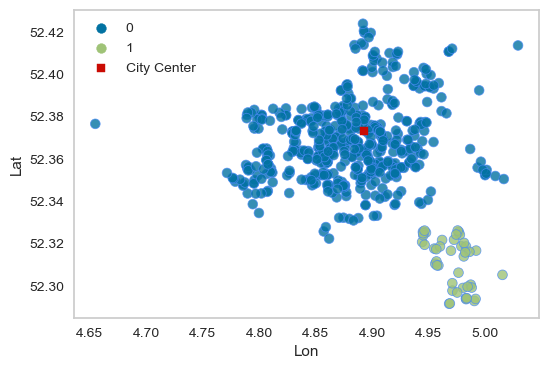

In [38]:
# Firstly, let's plot Lat vs Lon, observe where the city center is located, and highlight the Regions
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(
    data=data_train,
    x="Lon",
    y="Lat",
    ax=ax,
    hue="Region",
    color= '#F9812A',
    alpha=0.8,
    edgecolor='#4C8BF5',
)
# add a dot to plot the city center
plt.scatter(
    x=Lon_Central, y=Lat_Central, color="r", s=30, marker="s", label="City Center"
)
plt.legend()
plt.show()

In [39]:
def euclidean_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Compute the euclidean distance between two points tailored for geographical coordinates
    """
    deglen = 110.25
    x = lat2 - lat1
    y = (lon2 - lon1) * np.cos(lat1)
    return deglen * np.sqrt(x * x + y * y)

In [40]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [41]:
def manhattan_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the distances between the (Lat, Lon) coordinates
    """
    return np.abs(lat1 - lat2) + np.abs(lon1 - lon2)

In [42]:
# generate distance features
data_train = data_train.assign(
    **{
        "Euclidean_distance": lambda df: euclidean_distance(
            df["Lat"], df["Lon"], Lat_Central, Lon_Central
        ),
        "Haversine_distance": lambda df: haversine_distance(
            df["Lat"], df["Lon"], Lat_Central, Lon_Central
        ),
        "Manhattan_distance": lambda df: manhattan_distance(
            df["Lat"], df["Lon"], Lat_Central, Lon_Central
        ),
    }
)

# append new features to quantitative list
quantitative_list.extend(["Euclidean_distance","Haversine_distance","Manhattan_distance"])
new_features_list.extend(["Euclidean_distance","Haversine_distance","Manhattan_distance"])

In [43]:
# comparing the distance features with the one relying on geopandas library  
data_train[["Euclidean_distance",'Haversine_distance',
       'Manhattan_distance',"km_to_centre"]].describe()

,Euclidean_distance,Haversine_distance,Manhattan_distance,km_to_centre
count,552.000000,552.000000,552.000000,552.000000
mean,3.442045,3.890550,0.061132,3.899339
std,2.126548,2.439841,0.040442,2.445494
min,0.069644,0.083849,0.001246,0.084119
25%,1.933901,2.145871,0.031502,2.148869
50%,2.988560,3.328825,0.049638,3.337257
75%,4.604971,5.053349,0.082571,5.068220
max,13.496191,16.153704,0.241351,16.205840


* From the summary statistics, one can observe `km_to_centre` created via **geopandas** is similar to the direct extraction of `Haversine_distance` via **numpy**, but the latter is more advantageous in being easily maintained. 



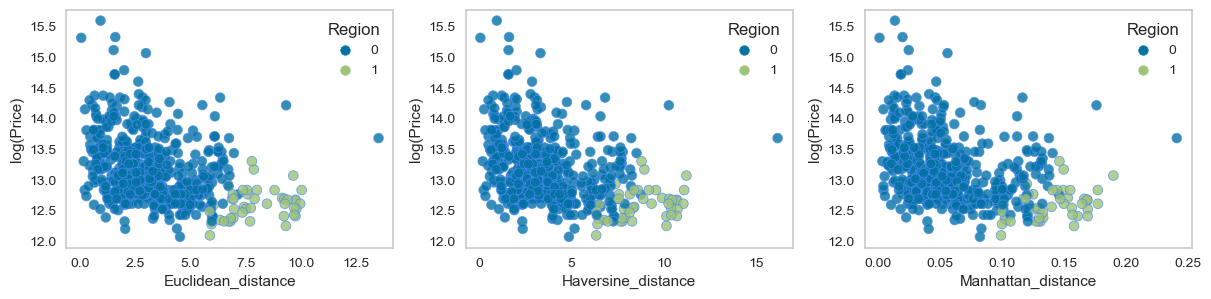

In [44]:
# Plot distance features with respect to the target and highlight the different regions
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
fig.tight_layout(w_pad=2.0)

for i, feature in zip(
    [0, 1, 2], ["Euclidean_distance", "Haversine_distance", "Manhattan_distance"]
):
    sns.scatterplot(
        data=data_train,
        x=feature,
        y="log(Price)",
        ax=axs[i],
        hue="Region",
        color= '#F9812A',
        alpha=0.8,
        edgecolor='#4C8BF5',
    )
    


* The features derived from (`lat`, `lon`) correlate negatively with `log(Price)`, validating our hypothesis that houses further from the city centre tend to be cheaper. 
* Furthermore, we observe that `Region=1` is more distant from the city centre, and the house price is lower than `Region=0`. 
* Finally, we expect to consider only one of the three features for model prediction since they all present a very similar pattern.

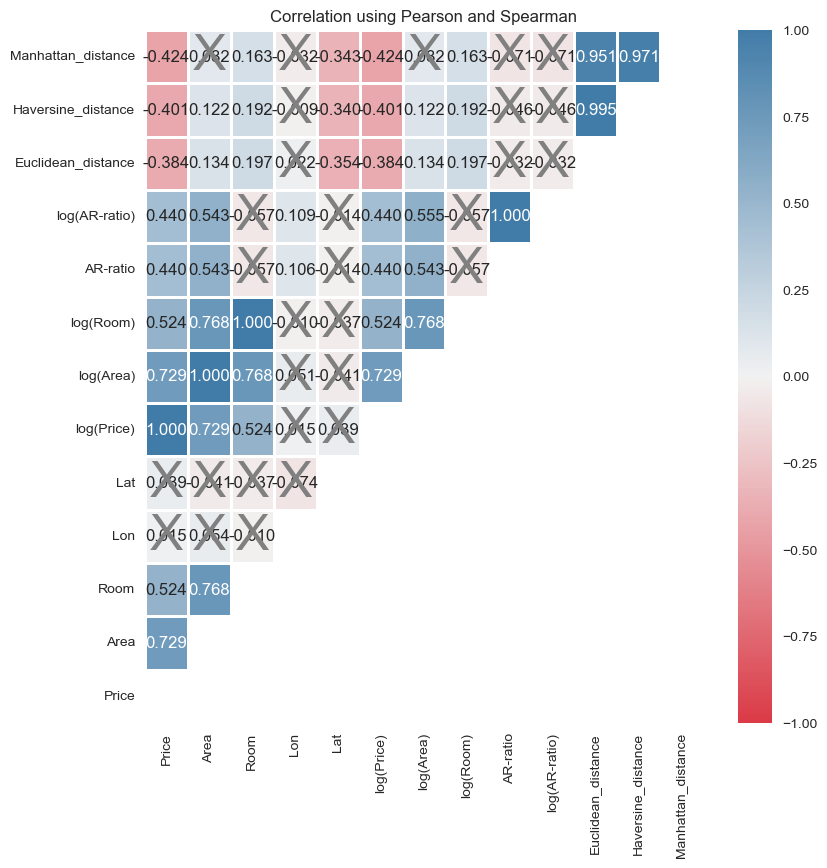

In [45]:
# Check all correlations using a correlogram
_ = plot_correlogram(
    data=data_train[quantitative_list],
    check_norm=True,
    dropna="pairwise",
    font_scale=1.2,
    show_p=True,
    figsize=(9, 9),
)

**3. Identify outliers and points of high leverage and re-run statistical tests to assess their impact.** 

* Checked this [article](https://online.stat.psu.edu/stat462/node/170/#:~:text=In%20short%3A,is%20particularly%20high%20or%20low.) to understand the difference between **outliers** and **high-leverage points**.

- **Method 1a**: assess the impact of high leverage points based on data visualisation
    * By a visual inspection, one can observe two points of high leverage for `Manhattan_distance > 0.20` and one additional point for `log(AR-ratio) > 5`. 

In [46]:
# display points with Manhattan distance > 0.2
display(data_train[lambda x: (x["Manhattan_distance"] > 0.2)].round(3))

# display summary statistics of Manhattan distance for comparison
display(data_train["Manhattan_distance"].describe().round(3).to_frame().T)

,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),...,Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
348,875000.0,"Ter Haarstraat 21 E, Amsterdam",1053LH,108.0,4.0,4.655,52.377,13.682,4.682,1.386,...,1053,0,5,3,LH,27.0,3.296,13.496,16.154,0.241


,count,mean,std,min,25%,50%,75%,max
Manhattan_distance,552.0,0.061,0.04,0.001,0.032,0.05,0.083,0.241


In [47]:
# display points with log(AR-ratio) > 5
display(data_train[lambda x: (x["log(AR-ratio)"] > 5)].round(3))

# display summary statistics of log(AR-ratio) for comparison
display(data_train["log(AR-ratio)"].describe().round(3).to_frame().T)

,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),...,Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
503,899000.0,"Uilengouw 2, Amsterdam",1027EZ,258.0,1.0,4.968,52.411,13.709,5.553,0.0,...,1027,0,2,7,EZ,258.0,5.553,6.104,6.577,0.112


,count,mean,std,min,25%,50%,75%,max
log(AR-ratio),552.0,3.247,0.301,2.603,3.042,3.219,3.419,5.553


* Check difference in correlation when removing the two high leverage points mentioned above.

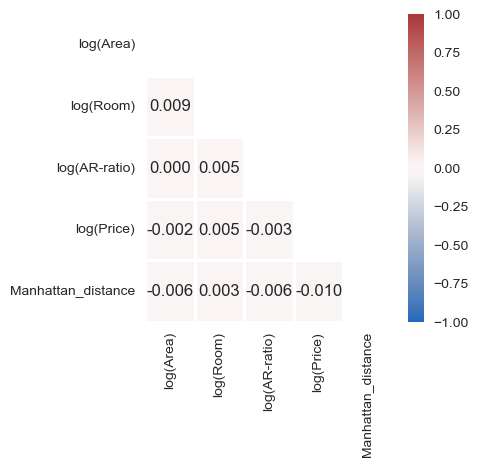

In [48]:
# Keep a subset of features to have a more compact heatmap
corr_feature_list = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "log(Price)",
    "Manhattan_distance",
]

# compute correlation matrix with original data
df_corr = correlation_analysis(
    data=data_train.filter(items=corr_feature_list),
    check_norm=True,
)

# compute correlation matrix with outliers removed
df_corr_no_outliers = correlation_analysis(
    data=data_train[
        lambda x: (x["Manhattan_distance"] < 0.2) & (x["log(AR-ratio)"] < 5)
    ].filter(items=corr_feature_list),
    check_norm=True,
)

# positive values will denote a higher correlation when removing outliers
delta_corr = (df_corr_no_outliers["r-value"] - df_corr["r-value"]).astype("float64")


# plot correlation matrix
corplot, ax = plt.subplots(figsize=(4, 4))
custom_cmap = sns.color_palette("vlag", as_cmap=True)  

_ = sns.heatmap(
    data=delta_corr,
    ax=ax,
    # Generate a mask for the upper triangle
    mask=np.triu(np.ones_like(delta_corr, dtype=bool)),
    # Customize colormap
    cmap=custom_cmap,
    center=0,
    linewidths=1,
    annot=True,
    fmt=".3f",
    vmin=-1,
    vmax=1,
)



* **Method 1b**: Check the difference in correlation when applying an Inter Quantile Range (IQR) outlier removal.

,var,method,outliers-removed,outliers-removed %,cutoff_lower,cutoff_upper,index
0,log(Area),"standard deviation, k=3.0",6,1.1,2.987081,5.867823,"[145, 193, 247, 449, 522, 530]"
1,log(Room),"inter-quartile range, k=1.5",32,5.8,0.667089,1.817817,"[5, 91, 106, 133, 145, 149, 152, 161, 191, 231..."
2,log(AR-ratio),"standard deviation, k=3.0",4,0.7,2.344849,4.149160,"[193, 386, 421, 501]"
3,log(Price),"inter-quartile range, k=1.5",9,1.6,11.736720,14.480635,"[65, 92, 145, 181, 193, 247, 263, 449, 522]"
4,Manhattan_distance,"inter-quartile range, k=1.5",13,2.4,-0.045101,0.159173,"[12, 14, 35, 51, 52, 61, 73, 132, 254, 286, 31..."


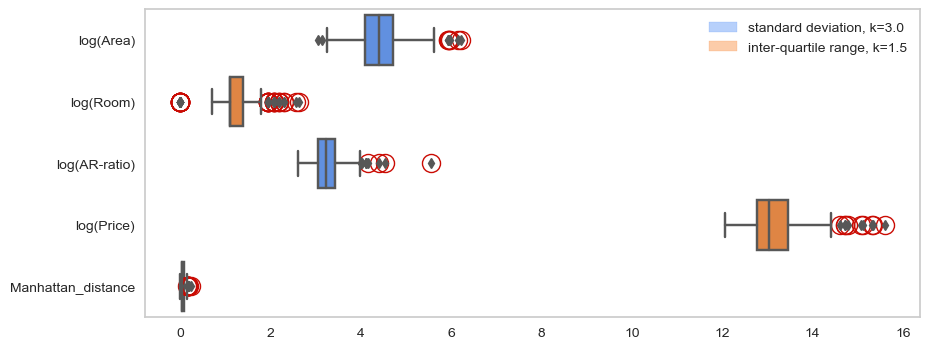

In [49]:
# Retrieve dataframe with outliers removed and visualise results
df_no_outlier_iqr, summary_outlier, fig = univariate_outlier_removal(
    data_train.filter(items=corr_feature_list),
    nonparam_args={"factor": 1.5},  # factor for IQR
    # return data with outliers removed
    remove=True,
    # show the outliers that will be removed
    plot=True,
    figsize=(10, 4),
)

# hide warnings
warnings.filterwarnings("ignore")
# show summary ouliers
summary_outlier

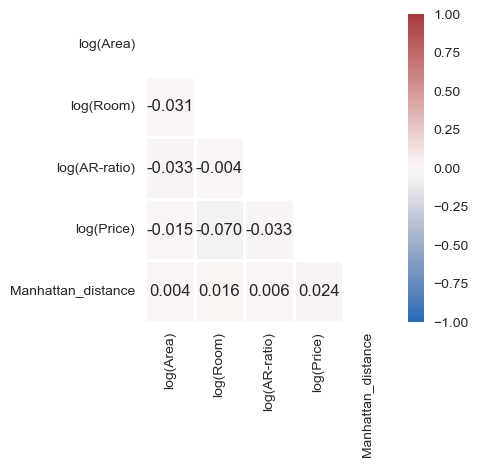

In [50]:
df_corr_no_outliers = correlation_analysis(
    data=df_no_outlier_iqr,
    check_norm=True,
)

# positive values will denote a higher correlation when removing outliers
delta_corr = (df_corr_no_outliers["r-value"] - df_corr["r-value"]).astype("float64")


corplot, ax = plt.subplots(figsize=(4, 4))
custom_cmap = sns.color_palette("vlag", as_cmap=True)  

_ = sns.heatmap(
    data=delta_corr,
    ax=ax,
    # Generate a mask for the upper triangle
    mask=np.triu(np.ones_like(delta_corr, dtype=bool)),
    # Customize colormap
    cmap=custom_cmap,
    center=0,
    linewidths=1,
    annot=True,
    fmt=".3f",
    vmin=-1,
    vmax=1,
)

By removing the outlier and rerunning the correlation analysis, we observe a negligible difference in terms of R-values.

- **Method 2**: Assessing the impact of high leverage and influential cases on regression coefficients 

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function to check the VIF of each feature
def vif(df, col_list):
    """
    Compute the Variance Inflation Factor (VIF) for each feature in a dataframe
    """
    vif = pd.DataFrame()
    vif["Features"] = col_list
    vif["VIF"] = [variance_inflation_factor(df[col_list].values, i) for i in range(len(col_list))]
    vif["VIF"] = vif["VIF"].round(3)
    return vif


In [52]:
# select features that were correlated with the target feature (log(Price))
corr_feature_list = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "log(Price)",
    "Manhattan_distance",
]

# create a new dataframe with only the selected features
reg_dat = data_train[corr_feature_list].copy()

#specify predictor and outcomes variables in the model 
y = reg_dat["log(Price)"]
x = reg_dat.drop(columns=['log(Price)'], axis=1 ) 

# display the VIF of each feature
vif(reg_dat, x.columns)

,Features,VIF
0,log(Area),inf
1,log(Room),inf
2,log(AR-ratio),inf
3,Manhattan_distance,3.316


In [53]:
# drop log(AR-ratio) due to its multicollinearity with log(Area) and log(Room)
x = x.drop(columns=['log(AR-ratio)'], axis=1 )
# display the VIF after removing log(AR-ratio)
vif(reg_dat, x.columns)

,Features,VIF
0,log(Area),17.828
1,log(Room),16.187
2,Manhattan_distance,3.316


In [54]:
import statsmodels.formula.api as smf
X = sm.add_constant(x)
# fit the model
model_fit = sm.OLS(y, X).fit()
print(model_fit.summary2())


                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.819    
Dependent Variable:  log(Price)       AIC:                -53.5015 
Date:                2024-01-08 19:58 BIC:                -36.2473 
No. Observations:    552              Log-Likelihood:     30.751   
Df Model:            3                F-statistic:        830.7    
Df Residuals:        548              Prob (F-statistic): 2.21e-203
R-squared:           0.820            Scale:              0.052759 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               9.3130   0.1136  81.9947 0.0000  9.0898  9.5361
log(Area)           0.9592   0.0327  29.3538 0.0000  0.8950  1.0234
log(Room)          -0.0416   0.0394  -1.0564 0.2913 -0.1190  0.0358
Manhattan_distance -5.9944   0.2449 -24.4812 0.0000 -6.4754 -5.513

- VIF detects multicollinearity in regression analysis. when including all numeric varibles from train set, `log(Room)` and `log(Area)` were both above thredsholds (i.e., >5)

- In the above regression, `log(Room)` is not statistically significant, and given it is highly correlated with  `log(Area)`, I thus remove this variable from the model. After removing it, the vif score indicated that no multicollinearity has been detected 


In [55]:
# drop log(AR-ratio) due to its multicollinearity with log(Area) and log(Room)
x = x.drop(columns=['log(Room)'], axis=1 )
# display the VIF after removing log(AR-ratio)
vif(reg_dat, x.columns)

,Features,VIF
0,log(Area),3.306
1,Manhattan_distance,3.306


In [56]:
# rerun the analysis without log(Room)
X = sm.add_constant(x)
model_fit = sm.OLS(y, X).fit()
print(model_fit.summary2())

                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.819    
Dependent Variable:  log(Price)       AIC:                -54.3786 
Date:                2024-01-08 19:59 BIC:                -41.4379 
No. Observations:    552              Log-Likelihood:     30.189   
Df Model:            2                F-statistic:        1245.    
Df Residuals:        549              Prob (F-statistic): 9.69e-205
R-squared:           0.819            Scale:              0.052770 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               9.3848   0.0910 103.1599 0.0000  9.2061  9.5635
log(Area)           0.9323   0.0205  45.5211 0.0000  0.8920  0.9725
Manhattan_distance -6.0253   0.2431 -24.7814 0.0000 -6.5029 -5.5477
------------------------------------------------------------------

* Results from regression confirmed that removing `log(Room)` does not change R^2, but yielding to better model fit (i.e., AIC, BIC) 

In [57]:
# Calculate leverage statistics
leverage = model_fit.get_influence().hat_matrix_diag

# Calculate Cook's distance
cook_distance = model_fit.get_influence().cooks_distance[0]

# Identify leverage points
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))

# Identify influential observations based on Cook's distance
influential_observations = np.where(cook_distance > 4 / len(x))

# Remove outliers using winsorization
x_winsorized = np.where(x > np.percentile(x, 95), np.percentile(x, 95), np.where(x < np.percentile(x, 5), np.percentile(x, 5), x))
y_winsorized = np.where(y > np.percentile(y, 95), np.percentile(y, 95), np.where(y < np.percentile(y, 5), np.percentile(y, 5), y))
# Fit the model with winsorized data
model_winsorized = sm.OLS(y_winsorized, sm.add_constant(x_winsorized)).fit()

# Remove influential observations based on Cook's distance
influential_observations = np.where(model_fit.get_influence().cooks_distance[0] > 4 / len(x))
x_clean = x.drop(influential_observations[0])
y_clean = y.drop(influential_observations[0])
# Fit the model with influential observations removed
model_clean = sm.OLS(y_clean, sm.add_constant(x_clean)).fit()
print(model_clean.summary2())


                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.830    
Dependent Variable:  log(Price)       AIC:                -189.5032
Date:                2024-01-08 19:59 BIC:                -176.7187
No. Observations:    524              Log-Likelihood:     97.752   
Df Model:            2                F-statistic:        1280.    
Df Residuals:        521              Prob (F-statistic): 8.62e-202
R-squared:           0.831            Scale:              0.040549 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               9.5703   0.0847 112.9856 0.0000  9.4039  9.7367
log(Area)           0.8853   0.0193  45.9633 0.0000  0.8474  0.9231
Manhattan_distance -5.9083   0.2201 -26.8431 0.0000 -6.3407 -5.4759
------------------------------------------------------------------

* Manually compute the influential cases & high leverage observations based on cook's distance and hat matrix diagnostics: results showed irrespective of with or without outliers, the coeffcients are not sensentive to the presence of outliers. 

The following section relies on [Cook's distance](https://rpubs.com/DragonflyStats/Cooks-Distance), which is a commonly used estimate of the influence of a data point when performing least squares regression analysis. Below section visualised the impact of influential cases on regression models. 

Index(['log(Area)', 'Manhattan_distance'], dtype='object')


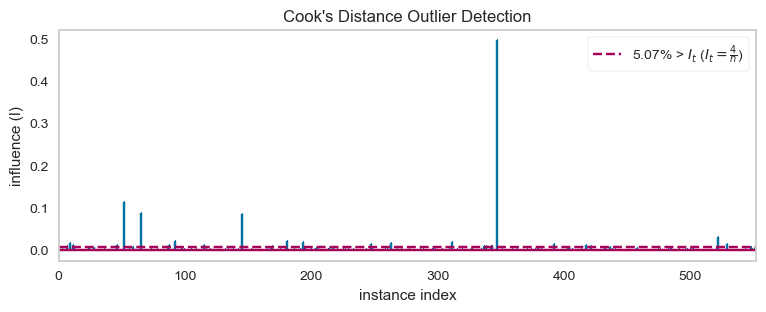

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [78]:
from yellowbrick.regressor import CooksDistance

fig, ax = plt.subplots(figsize=(9,3))
visualizer = CooksDistance()
visualizer.fit(X, y)

print(x.columns)
visualizer.show()

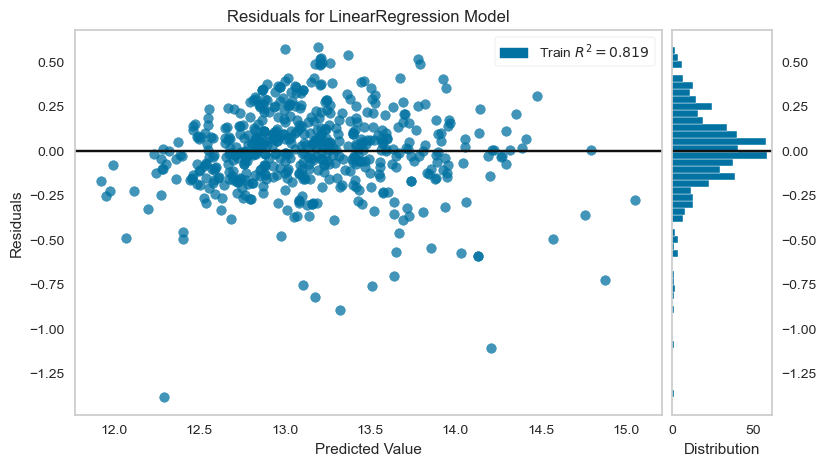

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [81]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()
fig, ax = plt.subplots(figsize=(9, 5))
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

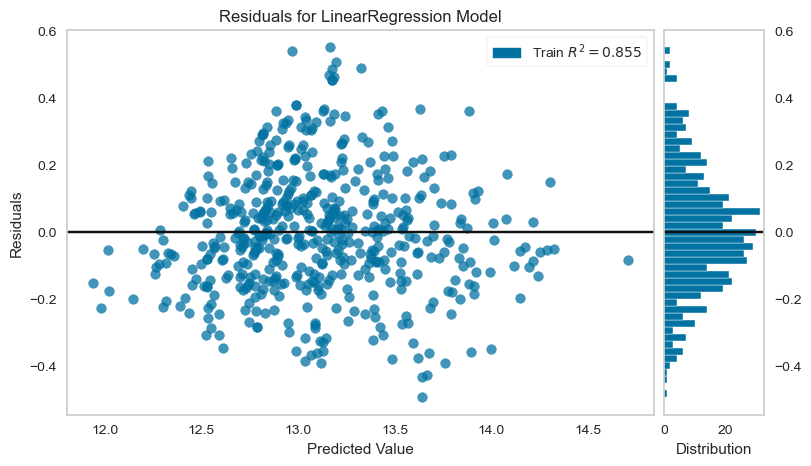

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [82]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X[i_less_influential], y[i_less_influential]

model = LinearRegression()
fig, ax = plt.subplots(figsize=(9, 5))
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

In [69]:
# Display influential cases 
data_train['influential'] = (visualizer.distance_ > visualizer.influence_threshold_)
data_train['infl_distance']=visualizer.distance_

print(f"There are {len(data_train[data_train['influential']==True])} influential cases detected from train set")

df_influential = data_train[data_train['influential']==True].sort_values(by='infl_distance', ascending= False)

display(df_influential.sample(3))

There are 28 influential cases detected from train set


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),...,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance,influential,infl_distance
52,1495000.0,"Dorpsstraat Holysloot 62, Amsterdam",1028BE,214.0,5.0,5.029122,52.413550,14.217637,5.365976,1.609438,...,2,8,BE,42.8,3.756538,9.322957,10.270411,0.176522,True,0.114662
312,475000.0,"Leghornstraat 4, Amsterdam",1109BW,118.0,5.0,5.015376,52.305296,13.071070,4.770685,1.609438,...,0,9,BW,23.6,3.161247,9.645282,11.220348,0.190120,True,0.020000
393,1050000.0,"Nieuwe Keizersgracht 570 L, Amsterdam",1018VG,63.0,3.0,4.908850,52.365524,13.864301,4.143135,1.098612,...,1,8,VG,21.0,3.044522,1.212321,1.363332,0.023366,True,0.014090


Taking above insights together, one can conclude that removal of influential cases and high leverage observations does not have a significant impact on the model


**4. If new features are created, save a new dataframe, ideally in [parquet](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html) format, to retain metadata information.**

💁‍♂️ If you also have the validation set, apply the same transformations and save an additional dataframe.

ℹ️ `DataFrame.to_parquet()` requires [pyarrow](https://pypi.org/project/pyarrow/) and [fastparquet](https://pypi.org/project/fastparquet/) libraries.

In [70]:
# drop influential metrics and those features created via less maintain package(i.e., geopandas)
data_train= data_train.drop(columns=['influential','infl_distance','Borough', 'Borough_id','km_to_centre'], axis=1 )
# summarise output of feature engineering on train set 
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 553
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Price               552 non-null    float64 
 1   Address             552 non-null    category
 2   Zip                 552 non-null    object  
 3   Area                552 non-null    float64 
 4   Room                552 non-null    float64 
 5   Lon                 552 non-null    float64 
 6   Lat                 552 non-null    float64 
 7   log(Price)          552 non-null    float64 
 8   log(Area)           552 non-null    float64 
 9   log(Room)           552 non-null    float64 
 10  Zip_num             552 non-null    category
 11  Region              552 non-null    category
 12  Location            552 non-null    category
 13  District            552 non-null    category
 14  Delivery_area       552 non-null    category
 15  AR-ratio            552 non-null    floa

In [71]:
# Apply equal transformations made to the train set to the validation set
data_val = (
    # load csv
    pd.read_csv("./data/data_val.csv")
    # remove rows missing values, if any
    .dropna(how="any")
    # drop duplicates, if any
    .drop_duplicates()
    # create log-transformed of skewed features, namely Price, Area and Room
    .assign(
        **{
            "log(Price)": lambda df: np.log(df["Price"]),
            "log(Area)": lambda df: np.log(df["Area"]),
            "log(Room)": lambda df: np.log(df["Room"]),
        }
    )
    # remove any space in the Zip string
    .assign(Zip=lambda df: df["Zip"].str.replace(" ", ""))
    # create new features from Address and Zip
    .assign(
        **{
            "Zip_num": lambda df: df["Zip"].str[:4].astype(int),  # first 4 digits
            "Region": lambda df: df["Zip"].str[1].astype(int),  # second digit
            "Location": lambda df: df["Zip"].str[2].astype(int),  # third digit
            "District": lambda df: df["Zip"].str[3].astype(int),  # fourth digit
            "Delivery_area": lambda df: df["Zip"].str[4:],  # from fifth digit
        }
    )
    # create AR-ratio and the corresponding log transform feature
    .assign(
        **{
            "AR-ratio": lambda df: df["Area"] / df["Room"],
            "log(AR-ratio)": lambda df: np.log(df["Area"] / df["Room"]),
        }
    )
    # generate distance features
    .assign(
        **{
            "Euclidean_distance": lambda df: euclidean_distance(
                df["Lat"], df["Lon"], Lat_Central, Lon_Central
            ),
            "Haversine_distance": lambda df: haversine_distance(
                df["Lat"], df["Lon"], Lat_Central, Lon_Central
            ),
            "Manhattan_distance": lambda df: manhattan_distance(
                df["Lat"], df["Lon"], Lat_Central, Lon_Central
            ),
        }
    )
)

data_val.shape

(184, 20)

In [72]:
# assert that the columns are the same in both train and validation set
assert data_train.columns.all() == data_val.columns.all()

In [ ]:
# save dataset with additional features in parquet format to retain data type.
data_train.to_parquet("./data/data_train_processed.parquet")

# save validation set in the same format
data_val.to_parquet("./data/data_val_processed.parquet")

**5. Generate a summary report. Below are a few bullet points you can reference:**
- **a.** Annotate the candidate features that have shown a meaningful relationship with the target;
- **b.** Mention any significant relationships between features that can lead to multicollinearity issues;
- **c.** Eventual outliers and points of high leverage and their impact;
- **d.** Anything else that is noteworthy for model training.


- `Area` and `Room`, `AR-ratio` and the features created from `lat` and `lon` are significantly correlated with `Price` with the highest correlation measured between `Area` and `Price` which is above 0.7;
- `Area` and `Room` are highly correlated, potentially leading to multicollinearity issues; hence we might expect that only `Area` is included in the final model. This is also true for the three types of distance derived from the geographical coordinates;
- It is recommended to rely on the log-transformed features instead of the original one since they are close to a normal distribution;
- Even though extreme samples have been observed, their impact appears negligible.
- Lastly, some features generated from external package (i.e.,geopandas) were dropped in the end, mainly due to they were derived from less committed packages, yielding to potential risk of introducing missing not at random values as well as its long-term maintenance costs. 